In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import helpers

sys.path.append(os.path.join('..'))
from counterfactual.curve import * 
from counterfactual.utility import *
from counterfactual.plot import *
from counterfactual.utils import *
from counterfactual.optim import *


/Users/dinouye/anaconda3/envs/adp-env-3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
../counterfactual/utils.py:4: UserWarning: Please use `funcs` module instead of `utils` module. Renamed to avoid confusion with `utility` module.
  warnings.warn('Please use `funcs` module instead of `utils` module. '


In [2]:
res = helpers.fetch_german_data()
df = res['dataframe']
X = res['X']
y = res['y']
dtypes = res['dtypes']
feature_labels = res['feature_labels']

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0)
pipe = make_pipeline(
    OneHotEncoder(sparse=False, categorical_features=is_categorical(dtypes), 
                  n_values=np.array([len(dtype.categories) for dtype in dtypes if hasattr(dtype, 'categories')])),
    StandardScaler(),
    RandomForestClassifier(max_features=None, random_state=2)
)
param_grid = {
    'randomforestclassifier__max_depth': [4, 5, 6],
    'randomforestclassifier__n_estimators': [100, 200, 400],#[1, 2, 3, 4, 5],
}
rerun_cv_search = False  # Make true if you want to rerun CV search for best parameter
if rerun_cv_search:
    search = GridSearchCV(pipe, param_grid, iid=False, cv=StratifiedKFold(5, random_state=0),
                          return_train_score=False, refit=True)
    search.fit(X_train, y_train)
    classifier = search.best_estimator_
    print(search.best_params_)
    print(search.best_score_)
else:
    # Just use known hyperparameters from previous run to simplify notebook run
    best_params = {
        'randomforestclassifier__max_depth': param_grid['randomforestclassifier__max_depth'][2], 
        'randomforestclassifier__n_estimators': param_grid['randomforestclassifier__n_estimators'][2]}
    pipe = make_pipeline(
        OneHotEncoder(sparse=False, categorical_features=is_categorical(dtypes), 
                      n_values=np.array([len(dtype.categories) for dtype in dtypes if hasattr(dtype, 'categories')])),
        StandardScaler(),
        RandomForestClassifier(
            max_depth=best_params['randomforestclassifier__max_depth'],
            n_estimators=best_params['randomforestclassifier__n_estimators'],
            max_features=None, random_state=2)
    )
    pipe.fit(X_train, y_train)
    classifier = pipe
    print(best_params)

def random_forest_model(X, classifier=classifier):
    func = classifier.predict_proba
    if np.asarray(X).ndim == 1:
        return func(X.reshape(1, -1))[0][1]
    return func(X)[:, 1]

/Users/dinouye/anaconda3/envs/adp-env-3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 400}


In [6]:
x0 = X[0, :]
random_forest_model(x0, classifier=classifier)
# Should be 0.9142299850932755

0.9142299850932755

In [7]:
scale = np.ones(x0.shape[0])
num_features = [i for i in range(len(dtypes)) if dtypes[i] == 'float64']
max_vals = np.max(X, axis=0)
min_vals = np.min(X, axis=0)
for i in num_features:
    scale[i] = 0.01 * (max_vals[i] - min_vals[i])

In [8]:
def compute_grad(x0, model, scale):
    # select numerical values
    num_features = [i for i in range(len(dtypes)) if dtypes[i] == 'float64']
    vv = np.zeros(x0.shape[0])
    vv[num_features] = 1
    pdiff = []
    for ii in range(x0.shape[0]):
        pdiff.append((model(x0 + vv * scale) - model(x0)) / scale[ii])
    return np.asarray(pdiff)

# Comparison to local model
def create_local_model(x0, model, scale):
    gradf = compute_grad(x0, model, scale)
    def local_model(X): # local model
        if np.asarray(X).ndim == 1:
            return model(x0) + np.dot(X - x0, gradf)
        return np.ones(X.shape[0]) * (model(x0) + np.dot(X - x0, gradf))
    return local_model

def create_constant_utility(x0, model):
    return GlobalModelUtility(model=model, other_model=create_local_model(x0, model, scale))

x0 = X[1, :]
# Could change to 3 if you want to see optimization over more than 1 coordinate
n_numeric_change = np.arange(1) + 1
constant_utility = create_constant_utility(x0, random_forest_model)
best_curves_constant = [
    optimize_curve(x0, constant_utility, X, max_numeric_change=nc, dtypes=dtypes)
    for nc in n_numeric_change
]

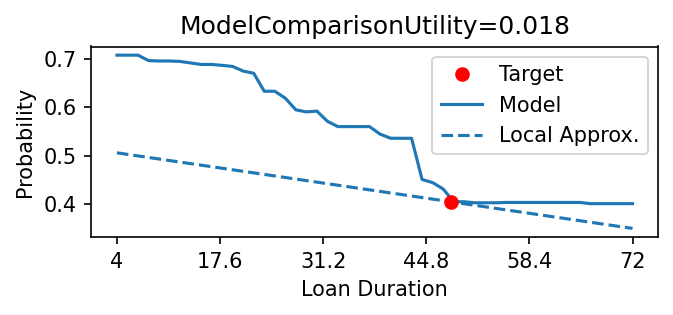

In [9]:
def plot_curves(best_curves, utility):
    n_change = len(best_curves)
    fig, axes = plt.subplots(n_change, 1, figsize=np.array([8, 4*n_change])*0.55, dpi=150, sharey=True)
    if n_change == 1:
        axes = np.array([axes])
    for c, ax in zip(best_curves, axes):
        plot_curve_vals(c, utility=utility, feature_labels=feature_labels,
                        other_model_label='Local Approx.', ax=ax)
    fig.tight_layout()
    
plot_curves(best_curves_constant, constant_utility)
ax = plt.gca()
ax.set_ylabel('Probability')
ax.set_xlabel('Loan Duration')

#plt.tight_layout()
plt.savefig('local2.pdf', bbox_inches='tight', pad_inches=0)